# King County Housing Data Analysis
The purpose of this notebook is to explore the `kc_house_data.csv` dataset, and attempt to model it. The notebook is laid out as follows:
1. Obtain  
 - Importing and getting a basic idea of what we're looking at.  
2. Clean  
 - Handle missing and placeholder values.  
3. Explore  
 - Generate visualizations to improve understanding.  
4. Expand  
 - Try to expand the dataset in useful ways.  
5. Model
 - Binning, scaling, regression, and neural nets.  
6. Interpret
 - Learning from the model.  

## Obtain
I'll begin by importing the dataset and taking a peak at it.

In [440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns


# loading the dataset
data = pd.read_csv('kc_house_data.csv')
print('dataset length: {}'.format(len(data)))
display(data.head())
data.columns


dataset length: 21597


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

What are we looking at, here?  
The first column `id` is somewhat ambiguous. However, using the `lat` and `long` columns and the [King County Parcel Viewer](https://www.kingcounty.gov/services/gis/Maps/parcel-viewer.aspx), it becomes clear that `id` is actually the parcel number.

In [441]:
data.rename(columns={'id':'parcel_number'}, inplace=True)
data.head(3)

,parcel_number,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


Using the same site, we can look at assessors' appraisals for previous years, and see that our `price` column doesn't appear to have been an assessment price; it's probably an actual sale price.  

Let's keep looking through the columns. Most of the rest of them are fairly self-explanatory, but there are a few ambiguous ones left to inspect: `view`, `condition`, `grade`, `sqft_living15`, and `sqft_lot15`.  

From information included with the dataset, `sqft_living15` and `sqft_lot15` are the averages of the respective columns for the 15 nearest properties. However, I'm uncertain whether they are the nearest 15 *from within this dataset* or the nearest 15 overall.

The columns `view`, `condition`, and `grade` are most likely from county assessment. Let's see what they contain, and how this compares to county assessors' designations.

In [442]:
# I suspect they're categorical
data[['view','condition','grade']].astype('category').describe()

,view,condition,grade
count,21534.0,21597,21597
unique,5.0,5,11
top,0.0,3,7
freq,19422.0,14020,8974


Column `view` appears to be an integer ranking on the interval $(0,5)$. The assessor's office also uses a field called `Views`, however theirs is far more detailed; includes quantized rankings per *type of view* (e.g. Seattle Skyline, Mt. Rainier, Cascade Mountains, etc.). I suspect, then, that our `view` field is probably some reduced ranking format of this assessment parameter.  

In the same way, `condition` and `grade` are likely synonymous with the assessment parameters by the same names.  

Before moving on to cleaning, let's look at a general description of the dataset.

In [443]:
data.describe()

,parcel_number,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


I can't help but notice the max value for `bedrooms` is 33. If this is an erroneous value, there should be only a few like it, at most. Notice, also, however, that the maximum `sqft_living` is also a whopping 13540. I suspect not that we're looking at erroneous entries, but rather that our dataset includes properties in a variety of residential occupancy zones.

In [444]:
data.loc[data['bedrooms'] > 9]

,parcel_number,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8748,1773100755,8/21/2014,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,...,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960
13301,627300145,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,...,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400
15147,5566100170,10/29/2014,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,...,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700
19239,8812401450,12/29/2014,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,...,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745


Looking up several of these parcels with the assessor, it's clear that there are, indeed, some 'multi-family dwellings' (e.g. duplex, triplex, etc.) in addition to mostly 'single family dwellings'.  
Also, as [you can see here](https://blue.kingcounty.com/Assessor/eRealProperty/Detail.aspx?ParcelNbr=2402100895), the 33 bedrooms appears to be an assessor's mistake.

In [445]:
# from the hand-drawn floor plan, it looks like there are actually 2 bedrooms
data.loc[data['bedrooms'] == 33,'bedrooms'] = 2

## Clean  
Now that I have a grasp of the kind of information included in the dataset, I'll look for and clean up missing values and placeholders.

In [446]:
print("Duplicate data present: {}\n".format(data.duplicated().any()))
print('NaN locations:')
nans = data.isna().sum()
[print("{}: {}".format(key,count)) for key,count in zip(nans.keys(),nans) if count > 0];

Duplicate data present: False

NaN locations:
waterfront: 2376
view: 63
yr_renovated: 3842


There seem to be three columns with explicit NaNs. I'll probably scrape as many of these values as I can, but even if I do, I don't know how to quantify `view` in the same way as the rest of the dataset. Let's see if I can safely replace the missing `view` values with a best-guess.

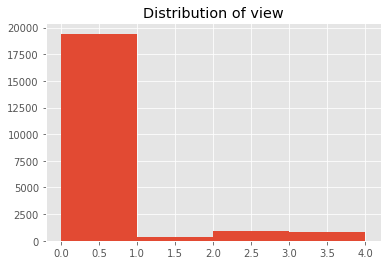

In [447]:
n_bins = int(data['view'].astype('category').describe()['unique']) - 1
data['view'].hist(bins=n_bins).set_title('Distribution of view');

In [448]:
# looks like they can safely become 0.0
data['view'].fillna(value=0.0,inplace=True)

For the NaNs in `waterfront` and `yr_renovated`, I can fill them in with something, but I'll save the indices of the ones I change, that way I can fill them with true values later if I end up scraping the assessor's data.

C:\Users\root\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\root\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\root\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\root\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two col

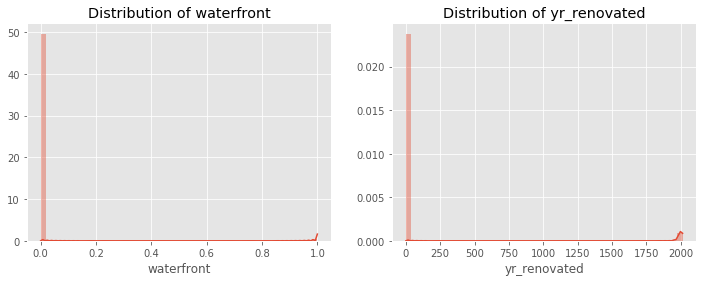

In [449]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
sns.distplot(data['waterfront'],ax=ax).set_title('Distribution of waterfront')
ax = fig.add_subplot(1, 2, 2)
sns.distplot(data['yr_renovated'],ax=ax).set_title('Distribution of yr_renovated');

In [450]:
# looks pretty safe to set them to zeros as well
waterfront_nans = data.loc[data['waterfront'].isna()].index
yr_renovated_nans = data.loc[data['yr_renovated'].isna()].index
data['waterfront'].fillna(value=0.0,inplace=True)
data['yr_renovated'].fillna(value=0.0,inplace=True)

As for placeholders, we can look at the dataset description from before: there are some outlier values we'll have to address later, but nothing looks unrealistic enough to be a placeholder. If they aren't placeholding by numeric value, they must be non-numeric.

In [451]:
placeholders = data.applymap(np.isreal).any() # check for non-numerics
[print('Non-numeric values in: {}'.format(placeholders.keys()[i])) for i,val in enumerate(placeholders) if not val];

Non-numeric values in: date
Non-numeric values in: sqft_basement


The `date` column will either be strings or datetime values, so it's probably safe to ignore its non-numeric qualities. However, we'd better have a look at `sqft_basement`.

In [452]:
data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

`sqft_basement` contains placeholder values `"?"`. Fortunately, we can infer the missing values:  
`sqft_above` $=$ `sqft_living` $-$ `sqft_basement`, ergo  
`sqft_basement` $=$ `sqft_living` $-$ `sqft_above`.

In [453]:
ph_sqft_living = data.loc[data['sqft_basement'] == '?','sqft_living']
ph_sqft_above = data.loc[data['sqft_basement'] == '?','sqft_above']

data.loc[data['sqft_basement'] == '?','sqft_basement'] = ph_sqft_living - ph_sqft_above 
data['sqft_basement'] = data['sqft_basement'].astype(float)
data['sqft_basement'].value_counts().head()

0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

### Datatypes

In [454]:
data.dtypes

parcel_number      int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [455]:
data['date'] = pd.to_datetime(data['date'],infer_datetime_format=False)
data['waterfront'] = data['waterfront'].astype(int)
data['view'] = data['view'].astype(int)
data['sqft_basement'] = data['sqft_basement'].astype(int)

## Explore

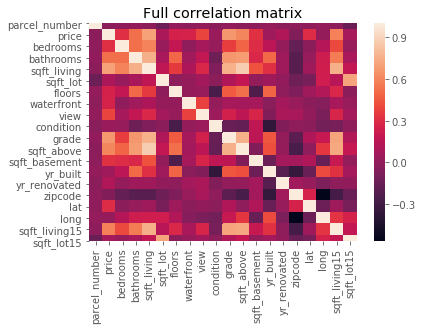

In [456]:
corr = data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Full correlation matrix');

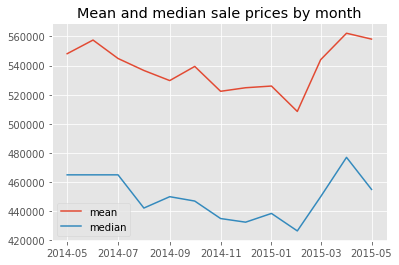

In [457]:
from datetime import datetime

monthly_means = data.groupby(data['date'].dt.strftime('%y/%m'))['price'].mean().to_frame().reset_index()
monthly_means['date'] = monthly_means['date'].apply(lambda x: datetime.strptime(x,'%y/%m'))
plt.plot(monthly_means['date'],monthly_means['price'])

monthly_medians = data.groupby(data['date'].dt.strftime('%y/%m'))['price'].median().to_frame().reset_index()
monthly_medians['date'] = monthly_medians['date'].apply(lambda x: datetime.strptime(x,'%y/%m'))
plt.plot(monthly_medians['date'],monthly_medians['price'])
plt.legend(["mean","median"])
plt.title("Mean and median sale prices by month");

In [458]:
print("-- date info --\nEarliest: {}\nLatest: {}".format(
    data['date'].min(),data['date'].max()))

-- date info --
Earliest: 2014-05-02 00:00:00
Latest: 2015-05-27 00:00:00


There's a little overlap in May. I'll account for that, so that we can get an idea of how many houses were sold by month.

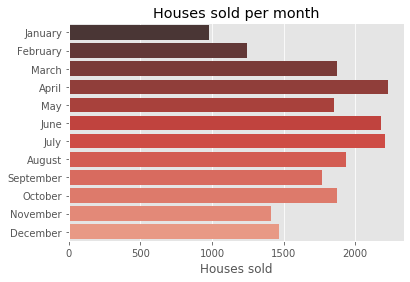

In [459]:
from dateutil.relativedelta import relativedelta

months = ['January','February','March','April',
          'May','June','July','August','September',
          'October','November','December']
one_year = data.loc[data['date'] <= (data['date'].min() + relativedelta(years=1))]
month_sold = one_year['price'].groupby(pd.DatetimeIndex(one_year['date']).month).count()
ax = sns.barplot(month_sold,months,palette='Reds_d')
ax.set(xlabel='Houses sold',title='Houses sold per month');

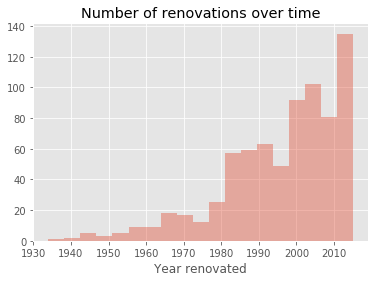

In [460]:
# number of renovations per year
renovated = data.loc[data['yr_renovated'] > 0,'yr_renovated']
ax = sns.distplot(renovated,kde=False)
ax.set(xlabel='Year renovated',title='Number of renovations over time');

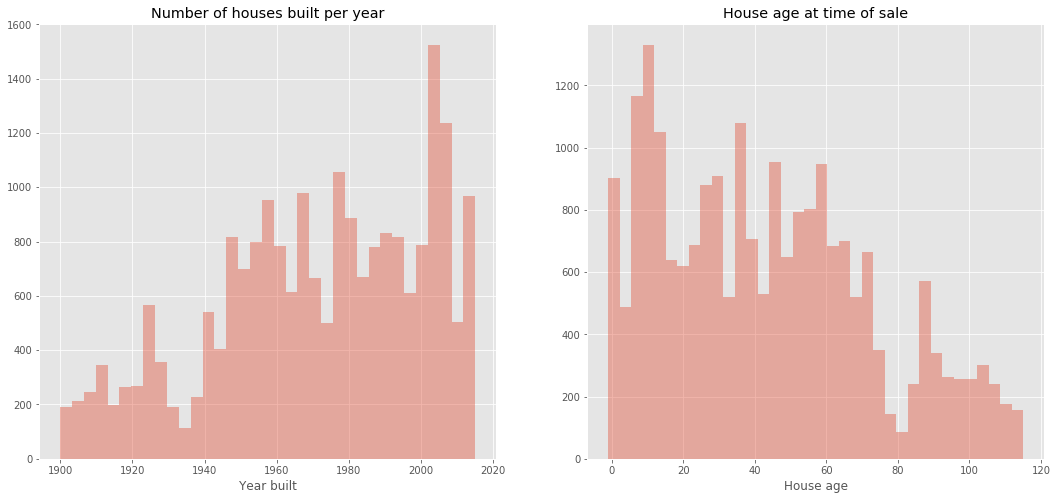

In [461]:
fig = plt.figure(figsize=(18,8))

# yr_renovated
ax = fig.add_subplot(1, 2, 1)
sns.distplot(data['yr_built'],kde=False,ax=ax)
ax.set(xlabel='Year built',title='Number of houses built per year')

# age of house at date of sale
ax = fig.add_subplot(1, 2, 2)
house_age = data['date'].apply(lambda x: x.year) - data['yr_built']
sns.distplot(house_age,kde=False,ax=ax)
ax.set(xlabel='House age',title='House age at time of sale');

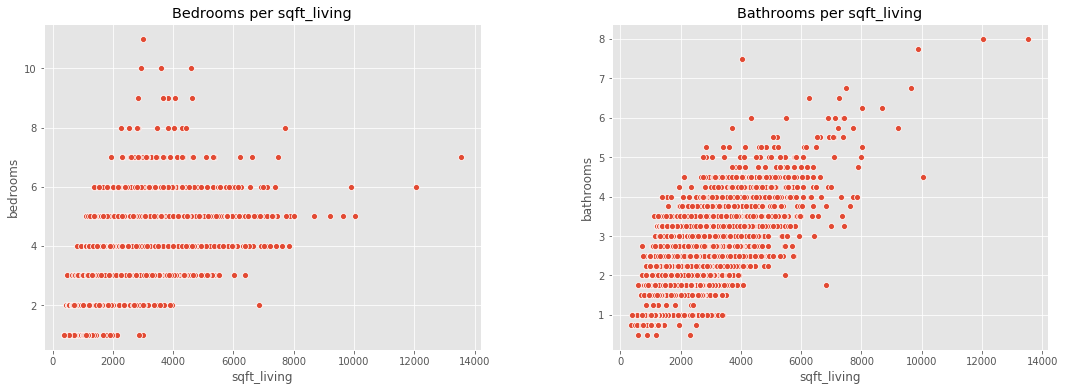

In [462]:
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data['sqft_living'],data['bedrooms'])
ax.set_title('Bedrooms per sqft_living')
ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data['sqft_living'],data['bathrooms'])
ax.set_title('Bathrooms per sqft_living');

### Quantized columns

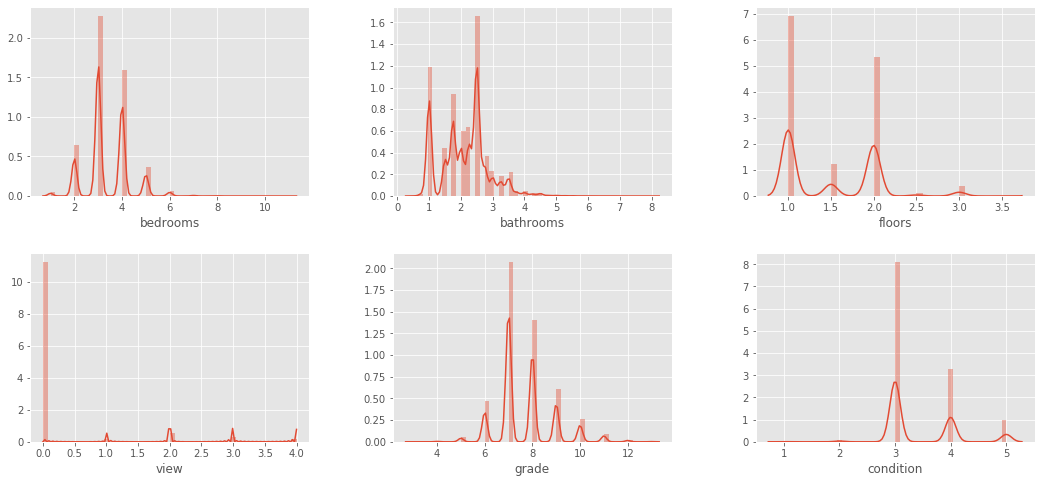

In [463]:
data_quantized = data[['bedrooms','bathrooms','floors',
                       'view','grade','condition']]

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,col in enumerate(data_quantized.columns):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(data_quantized[col],ax=ax)
plt.show()

### Continuous data

In [464]:
data_continuous = data[['sqft_living','sqft_lot','sqft_above',
                        'sqft_basement','yr_built','yr_renovated',
                        'sqft_living15','sqft_lot15']]

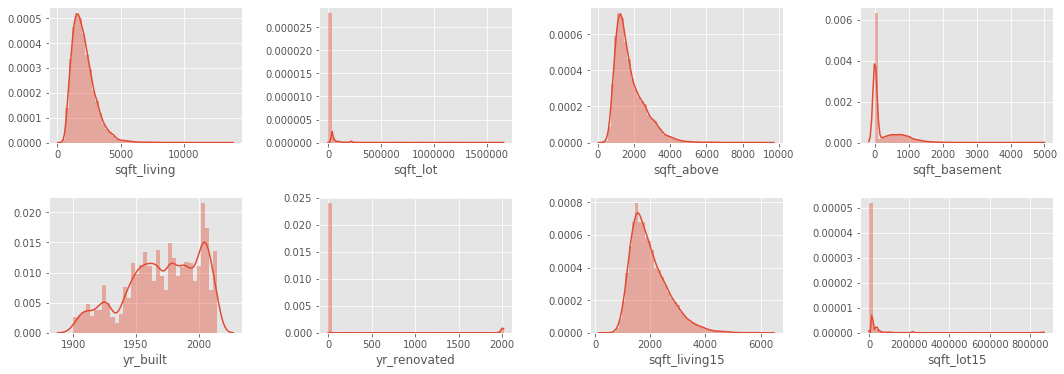

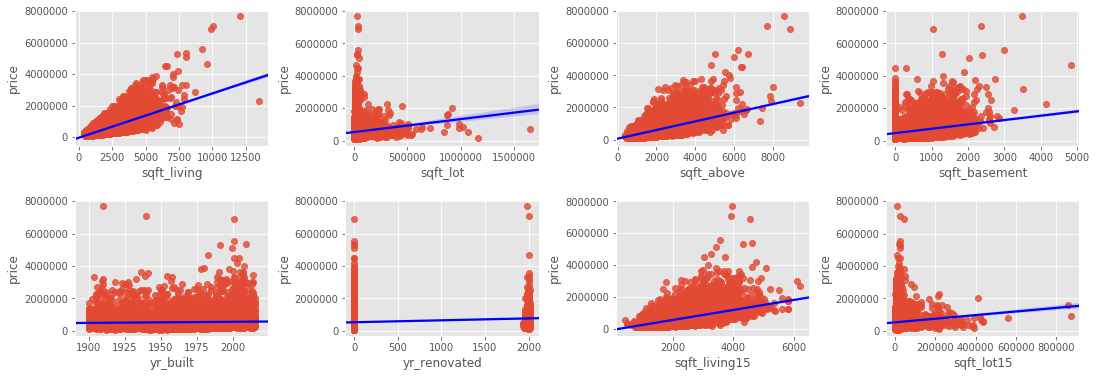

In [465]:
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,col in enumerate(data_continuous.columns):
    ax = fig.add_subplot(2, 4, i+1)
    sns.distplot(data_continuous[col],ax=ax)
plt.show()

fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,col in enumerate(data_continuous.columns):
    ax = fig.add_subplot(2, 4, i+1)
    sns.regplot(data_continuous[col],data['price'],ax=ax,line_kws={'color': 'blue'})
plt.show()

## Expand
Let's try to create some new features. 

### Neighborhoods
I suspect that the neighborhood and distance from nearest central buisness district may be important factors. Zipcodes could help with that, but they don't necessarily convey neighborhoods as experienced by residents.  

Instead, I'm going to use [this dataset I found online](https://gis-kingcounty.opendata.arcgis.com/datasets/neighborhood-centers-in-king-county-neighborhood-centers-point/data?page=5) to find each datapoint's nearest CBD and calculate the distance thereto.  

In [466]:
hoods = pd.read_csv('Neighborhood_Centers_in_King_County__neighborhood_centers_point.csv')
hoods.head(3)

,X,Y,OBJECTID,FEATURE_ID,CODE,NAME,ADDRESS,NEIGH_NUM,XCOORD,YCOORD,LONGITUDE,LATITUDE
0,-122.355548,47.723233,1,90001,Community Area/Business Center/Neighborhood,Bitter Lake Neighborhood,N 130th St & Greenwood Ave N,3,1.265776e+06,267518.406033,-122.355550,47.723232
1,-122.323274,47.708595,2,90002,Community Area/Business Center/Neighborhood,Northgate Neighborhood,NE Northgate Way & 5th Ave NE,28,1.273615e+06,262024.468858,-122.323276,47.708593
2,-122.295226,47.719280,3,90003,Community Area/Business Center/Neighborhood,Lake City Neighborhood,NE 125th & Lake City Way NE,21,1.280593e+06,265788.625044,-122.295228,47.719278


In [467]:
from tqdm.notebook import tqdm
from operator import itemgetter
from haversine import haversine # calculates distance given latitudes and longitudes

def find_cbd(df,hoods):
    ''' Finds nearest CBD and distance therefrom
    
    Parameters:
    df (pd.DataFrame): the King County Housing dataset
    hoods (pd.DataFrame): The Neighborhood Centers in King County dataset
    
    Returns:
    pd.DataFrame: a new dataframe containing nearest neighborhood and distance features
    
    '''
    nearest_hoods,dist_hoods = [],[]
    for row in tqdm(df.iterrows(),total=len(df)):
        lat = row[1]['lat']
        lon = row[1]['long']
        to_cbd = []
        for hood in hoods.iterrows(): # consider all neighborhoods
            dist = haversine((lat,lon),
                             (hood[1]['LATITUDE'],hood[1]['LONGITUDE']),
                             unit='mi')
            to_cbd.append({'CBD' : hood[1]['NAME'],
                           'DIST' : dist})
        sortd = sorted(to_cbd, key=itemgetter('DIST')) # sort by distance, ascending
        nearest_hoods.append(sortd[0]['CBD']) # nearest CBD
        dist_hoods.append(sortd[0]['DIST']) # distance thereto
    new_panda = pd.DataFrame()
    new_panda['nearest_hoods'] = nearest_hoods
    new_panda['dist_hoods'] = dist_hoods
    return new_panda

# saving
#hoods_data = find_cbd(data,hoods) # uncomment if saving
#hoods_data.to_csv('hoods_data.csv',index=False) # uncomment if saving

# loading
hoods_data = pd.read_csv('hoods_data.csv') # uncomment if loading

# join neighborhood data to the primary dataframe
data = pd.concat([data,hoods_data],join='inner',axis=1)

`nearest_hoods` will need to be numerically indexed.

In [468]:
data['nearest_hood'] = data['nearest_hoods'].astype('category')
names_of_neighborhoods = data['nearest_hood'].cat.categories
data['nearest_hood'] = data['nearest_hood'].cat.codes # numerically index
data.drop('nearest_hoods',axis=1,inplace=True)
data[['nearest_hood','dist_hoods','price']].head(3)

,nearest_hood,dist_hoods,price
0,32,1.032990,221900.0
1,30,0.879959,538000.0
2,13,0.741188,180000.0


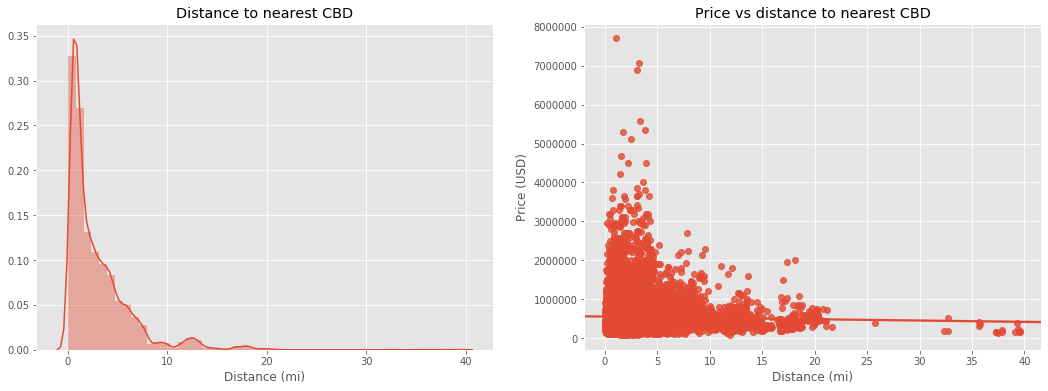

In [469]:
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
sns.distplot(data['dist_hoods'],ax=ax)
ax.set(xlabel='Distance (mi)',title='Distance to nearest CBD');
ax = fig.add_subplot(1, 2, 2)
sns.regplot(data['dist_hoods'],data['price'],ax=ax)
ax.set(xlabel='Distance (mi)',ylabel='Price (USD)',
       title='Price vs distance to nearest CBD');

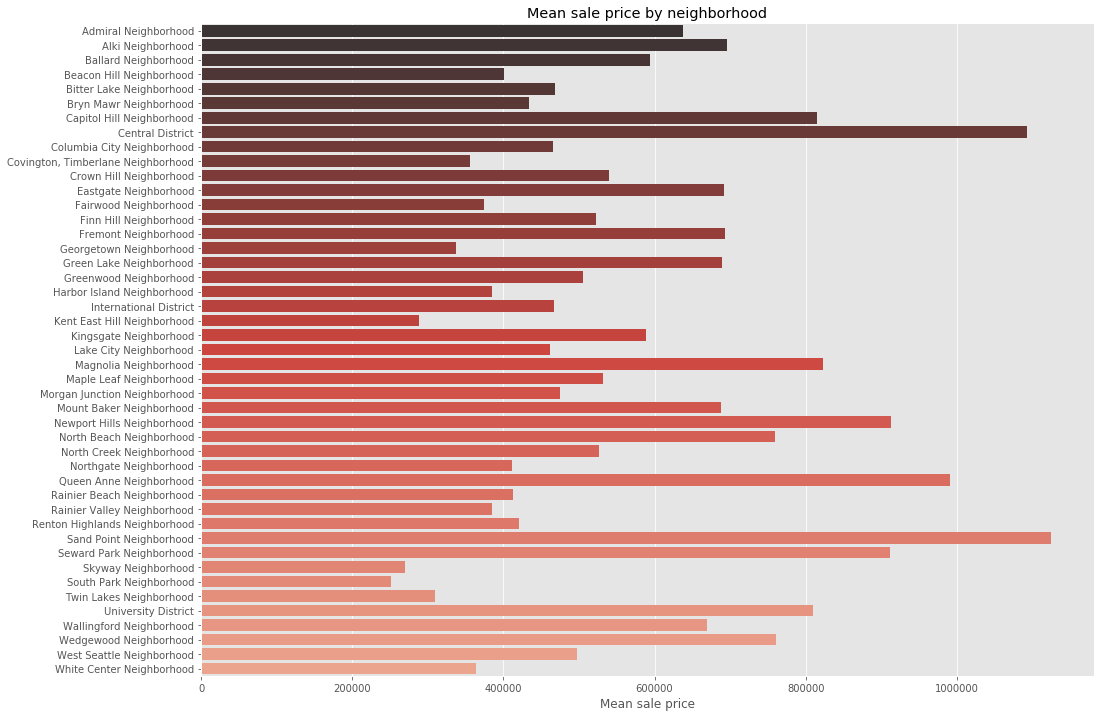

In [470]:
mean_hood_price = data.groupby(['nearest_hood'])['price'].mean()
plt.figure(figsize=(16,12))
ax = sns.barplot(mean_hood_price,names_of_neighborhoods,palette='Reds_d')
ax.set(xlabel='Mean sale price',title='Mean sale price by neighborhood');

To a native of King County, this won't look surprising. For example, Sand Point and the Central District are known to be affluent neighborhoods, while the International District, South Park, and White Center are places that one might prefer not to visit after sundown.

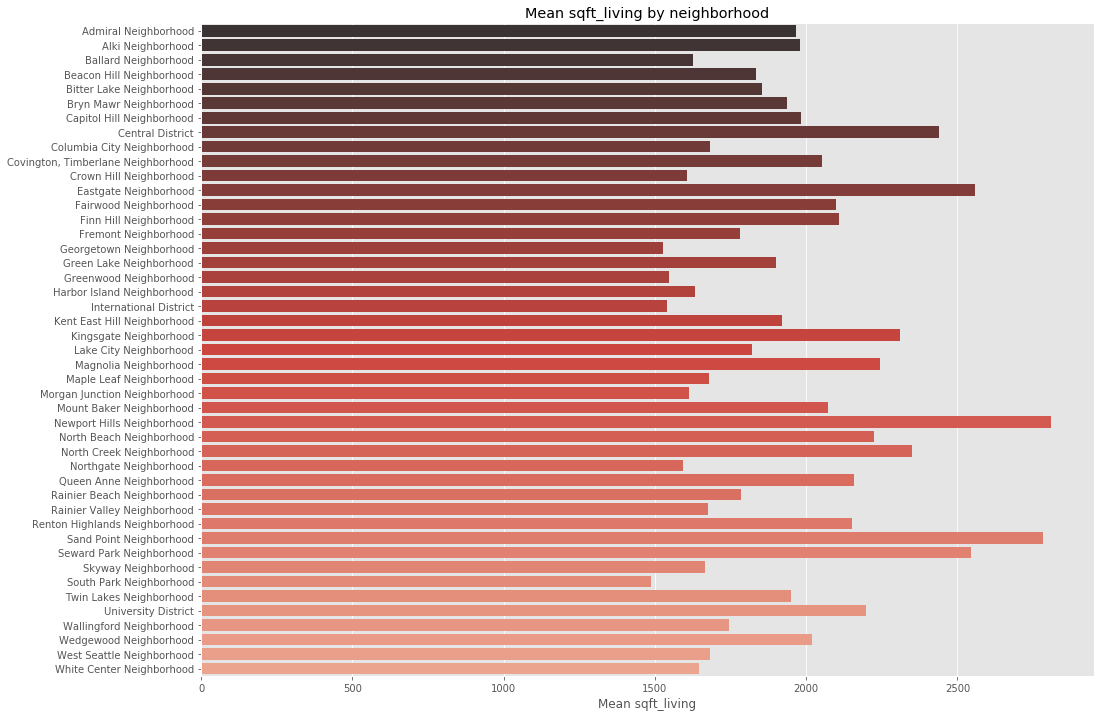

In [471]:
sqft_living_by_neighborhood = data.groupby(['nearest_hood'])['sqft_living'].mean()
plt.figure(figsize=(16,12))
ax = sns.barplot(sqft_living_by_neighborhood,names_of_neighborhoods,palette='Reds_d')
ax.set(xlabel='Mean sqft_living',title='Mean sqft_living by neighborhood');

### Nearest schools
Next I'll use the [School Sites in King County dataset](https://gis-kingcounty.opendata.arcgis.com/datasets/school-sites-in-king-county-schsite-point) to find nearest schools. It's a more recent dataset, but schools don't change often.  
I'll make a function to find the nearest schools and their distances, by type, for each property in the main dataset.

In [472]:
schools_df = pd.read_csv('School_Sites_in_King_County__schsite_point.csv')
schools_before = len(schools_df)
display(schools_df.head(3))
schools_df['CODE'].value_counts()

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,NAME,ABB_NAME,ADDRESS,ZIPCODE,LONG_CEN,LAT_CEN,SCH_CLASS,DISTRICT,PIN,MAJOR,MINOR,FEATUREDES,OSPI_CODE
0,-122.152303,47.608461,1,207,80,School-High,Sammamish High School,Sammamish,100 140th Ave SE,98005,-122.152305,47.608458,10.0,BELLEVUE,3.425059e+09,342505.0,9019.0,School-High,3282.0
1,-122.205415,47.768906,2,263,113,School-Elementary,Saint Brendan Catholic School,Saint Brendan,10049 NE 195th St,98011,-122.205416,47.768905,20.0,NORTHSHORE,5.260591e+08,52605.0,9084.0,School-Elementary,0.0
2,-122.348454,47.525265,3,884,527409,School-Elementary,Highland Park Elementary School,Highland Park,1012 SW Trenton St,98106,-122.348456,47.525263,10.0,SEATTLE,7.972603e+09,797260.0,3210.0,School-Elementary,2269.0


School-Elementary               345
School-Junior High/Middle        80
School-High                      73
School-Alternative               64
School-Other Facility            32
School-College or University     31
School-K-12                      17
Name: CODE, dtype: int64

In [473]:
def find_schools(df,sdf):
    ''' Finds distance to nearest school for each house in miles
    
    Parameters:
        df (pd.DataFrame): the King County Housing dataset
        cdf (pd.DataFrame): the School Sites in King County dataset
    
    Returns:
        array: distances (mi) to schools for each house in df
    '''
    school_types = sdf['CODE'].unique()
    dists_to_schools = pd.DataFrame(columns=school_types)
    nearest_schools = pd.DataFrame(columns=school_types)
    for row in tqdm(df.iterrows(),total=len(df)):
        school_distances = pd.Series(index=school_types)
        school_which = pd.Series(index=school_types)
        lat = row[1]['lat']
        lon = row[1]['long']
        for col in school_types:
            subset = sdf.loc[sdf['CODE'] == col]
            nearest = min(subset.iterrows(),
                          key=lambda p: haversine((p[1]['Y'],p[1]['X']),
                                                  (lat,lon),unit='mi'))
            school_distances[col] = haversine((nearest[1]['Y'],nearest[1]['X']),
                                              (lat,lon),unit='mi')
            school_which[col] = nearest[1]['ABB_NAME']
            
        dists_to_schools = dists_to_schools.append(school_distances,
                                                   ignore_index=True)
        nearest_schools = nearest_schools.append(school_which,
                                               ignore_index=True)
    return dists_to_schools,nearest_schools

# option to save/load
# saving
#dists_to_schools,nearest_schools = find_schools(data,schools_df)
#dists_to_schools.to_csv('distances_to_schools_by_type.csv',index=False)
#nearest_schools.to_csv('nearest_schools_by_type.csv',index=False)

# loading
dists_to_schools = pd.read_csv('distances_to_schools_by_type.csv')
nearest_schools = pd.read_csv('nearest_schools_by_type.csv')

display(dists_to_schools.head(3))
display(nearest_schools.head(3))

,School-High,School-Elementary,School-Alternative,School-Junior High/Middle,School-College or University,School-K-12,School-Other Facility
0,0.980736,0.130673,2.019210,1.730659,3.606699,2.525321,2.668727
1,0.885230,0.245892,0.559668,0.628985,1.621822,1.300072,1.948318
2,0.510869,0.111689,1.236571,1.236571,1.005689,2.114384,3.869594


,School-High,School-Elementary,School-Alternative,School-Junior High/Middle,School-College or University,School-K-12,School-Other Facility
0,Rainier Beach,Amazing Grace,Secondary Learning,Dimmit,City University,Renton Christian,Admin
1,Lakeside High,St. Matthew,Hazel Wolf,Lakeside Middle,North Seattle College,Shoreline Christian,Transportation
2,Inglemoor,Moorlands,Environmental and Adventure,Finn Hill,Bastyr,Cedar Park Christian,Transportation


It doesn't look like `School-Other Facility` is going to be particularly useful, so I'll remove those

In [474]:
dists_to_schools.drop('School-Other Facility',axis=1,inplace=True)
nearest_schools.drop('School-Other Facility',axis=1,inplace=True)

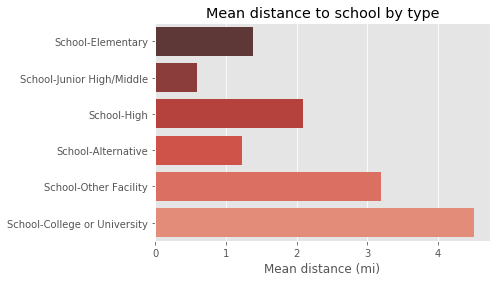

In [475]:
school_types = schools_df['CODE'].value_counts().index[:-1]
ax = sns.barplot(dists_to_schools.mean(),school_types,palette='Reds_d')
ax.set(xlabel='Mean distance (mi)',title='Mean distance to school by type');

It's no secret that proximity to good schools makes a big difference in housing demand.

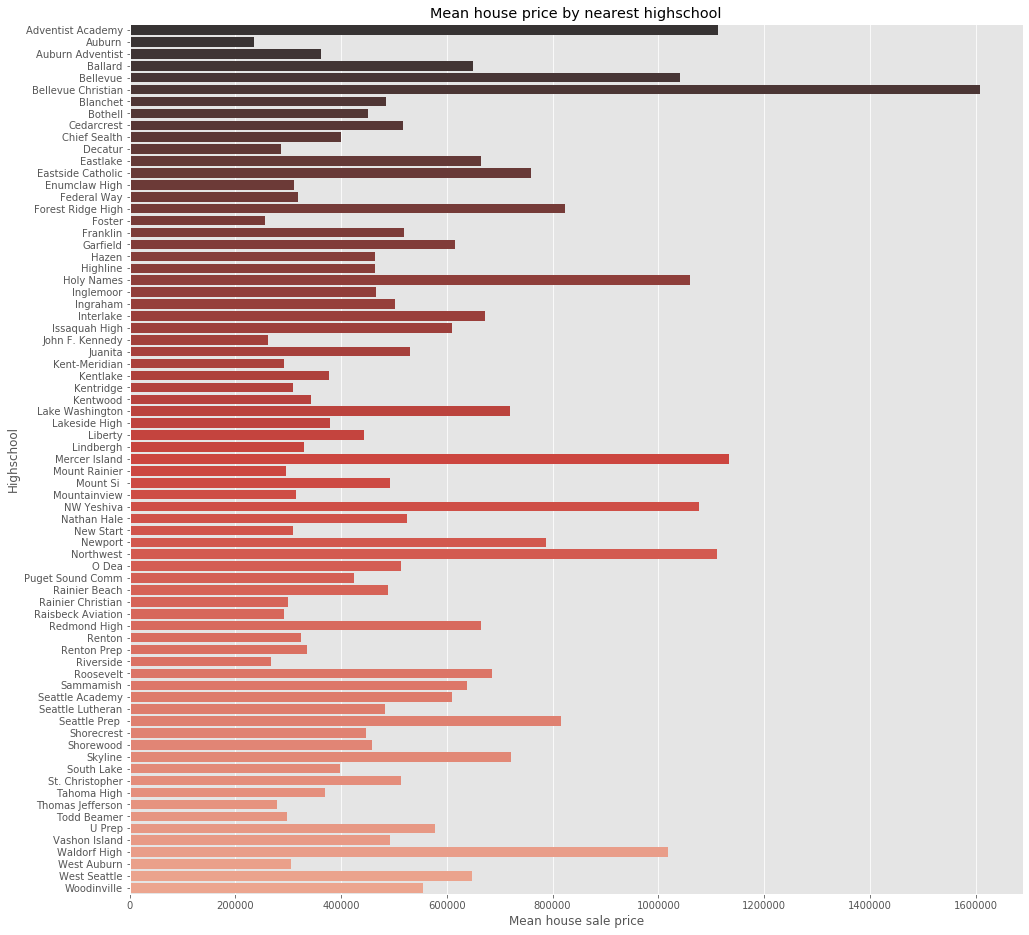

In [476]:
nearest_schools['price'] = data['price']
highschools = nearest_schools.groupby('School-High')['price'].mean()
nearest_schools.drop('price',axis=1,inplace=True)
highschool_names = highschools.index
plt.figure(figsize=(16,16))
ax = sns.barplot(highschools,highschool_names,palette='Reds_d')
ax.set(xlabel='Mean house sale price',ylabel='Highschool',
       title='Mean house price by nearest highschool');

In [477]:
nearest_schools = nearest_schools.apply(lambda x: x.astype('category'))
nearest_schools = nearest_schools.apply(lambda x: x.cat.codes)
nearest_schools.head(3)

,School-High,School-Elementary,School-Alternative,School-Junior High/Middle,School-College or University,School-K-12
0,47,6,50,10,5,11
1,33,274,23,32,12,13
2,22,191,12,16,1,3


We'll need to add the neighborhood and school dataframes to the main `data` dataframe.

In [478]:
# rename columns so they don't clash with those of `nearest_schools`
for col in dists_to_schools.columns:
    dists_to_schools.rename(columns={col:'dist_to_{}'.format(col)},inplace=True)
# then concatenate
data = pd.concat([data,nearest_schools],join='inner',axis=1)
data = pd.concat([data,dists_to_schools],join='inner',axis=1)
data.head(3)

,parcel_number,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,School-Alternative,School-Junior High/Middle,School-College or University,School-K-12,dist_to_School-High,dist_to_School-Elementary,dist_to_School-Alternative,dist_to_School-Junior High/Middle,dist_to_School-College or University,dist_to_School-K-12
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,False,0,...,50,10,5,11,0.980736,0.130673,2.019210,1.730659,3.606699,2.525321
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,False,0,...,23,32,12,13,0.885230,0.245892,0.559668,0.628985,1.621822,1.300072
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,False,0,...,12,16,1,3,0.510869,0.111689,1.236571,1.236571,1.005689,2.114384


## Modeling

### Transformations
Whether it's on a graph or not, data transformations are part of modeling. Let's begin by looking at ways we can transform features to better prepare them for regression.  
During data exploration, it was pretty clear that we have three main challenges to overcome:
- Several features are right skewed.
- Several relationships suffer from kurtosis.
- Several features are multimodal.

First let's look at the target, `price`, since changes there will alter the relationships with any other features.

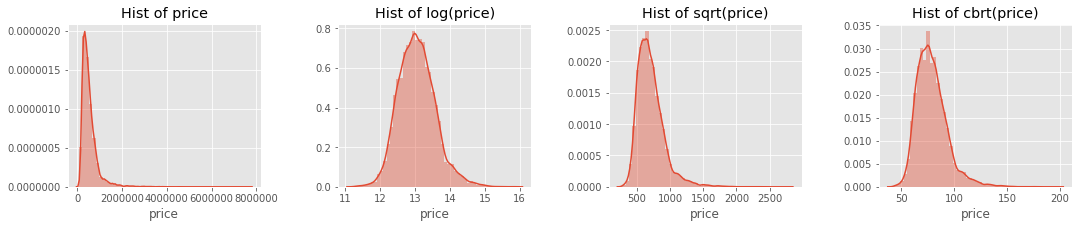

In [480]:
fig = plt.figure(figsize=(18,3))
fig.subplots_adjust(hspace=0.5,wspace=0.4)
ax = fig.add_subplot(1,4,1)
sns.distplot(data['price'],ax=ax)
plt.title('Hist of price')
ax = fig.add_subplot(1,4,2)
sns.distplot(np.log(data['price']),ax=ax)
plt.title('Hist of log(price)')
ax = fig.add_subplot(1,4,3)
sns.distplot(np.sqrt(data['price']),ax=ax)
plt.title('Hist of sqrt(price)')
ax = fig.add_subplot(1,4,4)
sns.distplot(np.cbrt(data['price']),ax=ax)
plt.title('Hist of cbrt(price)');

In [481]:
# let's change this now, since it'll influence all other relationships
data['price'] = np.log(data['price'])

Next I'll create a tool to visualize how transformations affect right skew.

In [482]:
def assess_rs_transformation(x,y):
    ''' Displays histogram and regression plot with various
        right-skew transformations for a given column
    
    Parameters:
        x (pd.Series): Series containing X axis data
        y (pd.Series): Series containing Y axis data
    
    Returns:
        None
    '''    
    fig = plt.figure(figsize=(18,8))
    fig.subplots_adjust(hspace=0.5,wspace=0.4)
    funcs = [lambda x:x,np.log,np.sqrt,np.cbrt]
    func_names = ['{} vs log({})','log({}) vs log({})','sqrt({}) vs log({})',
                  'cbrt({}) vs log({})','hist of {}','hist of log({})',
                  'hist of sqrt({})','hist of cbrt({})']
    
    for i in range(4):
        ax = fig.add_subplot(2,4,i+1)
        sns.regplot(funcs[i](x),y,ax=ax,line_kws={'color':'blue'})
        plt.title(func_names[i].format(x.name,y.name))
    for i in range(4,8):
        ax = fig.add_subplot(2,4,i+1)
        sns.distplot(funcs[i % 4](x),ax=ax)
        plt.title(func_names[i].format(x.name))
    plt.show()

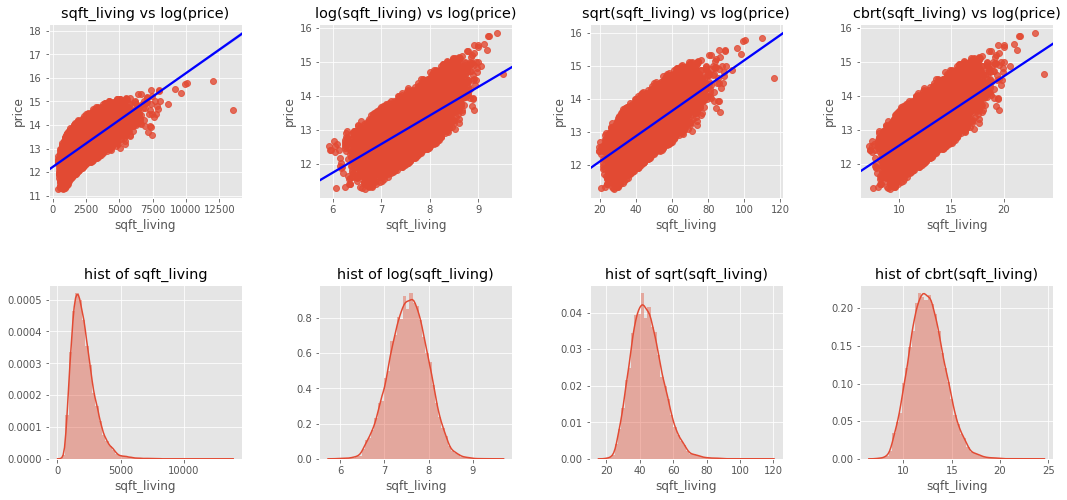

In [483]:
assess_rs_transformation(data_continuous['sqft_living'],data['price'])

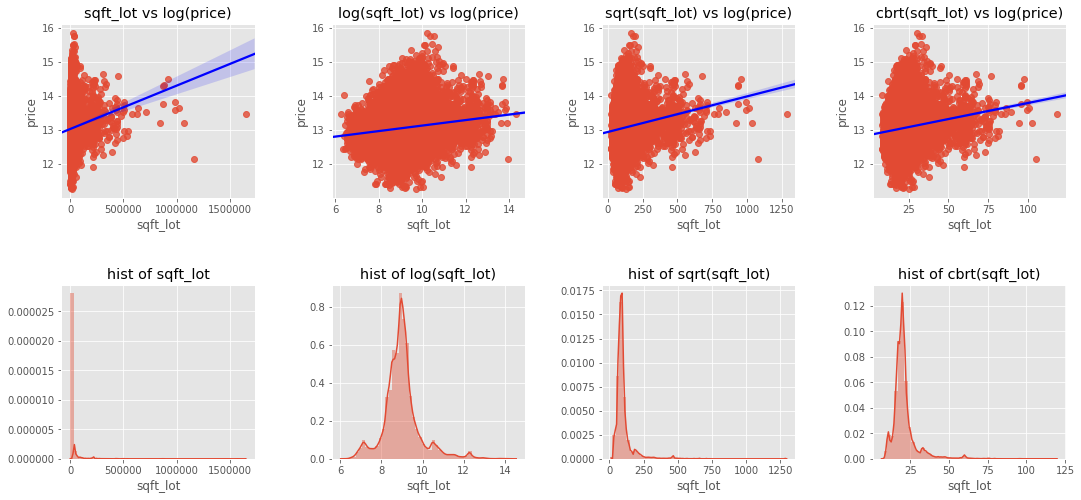

In [484]:
assess_rs_transformation(data_continuous['sqft_lot'],data['price'])

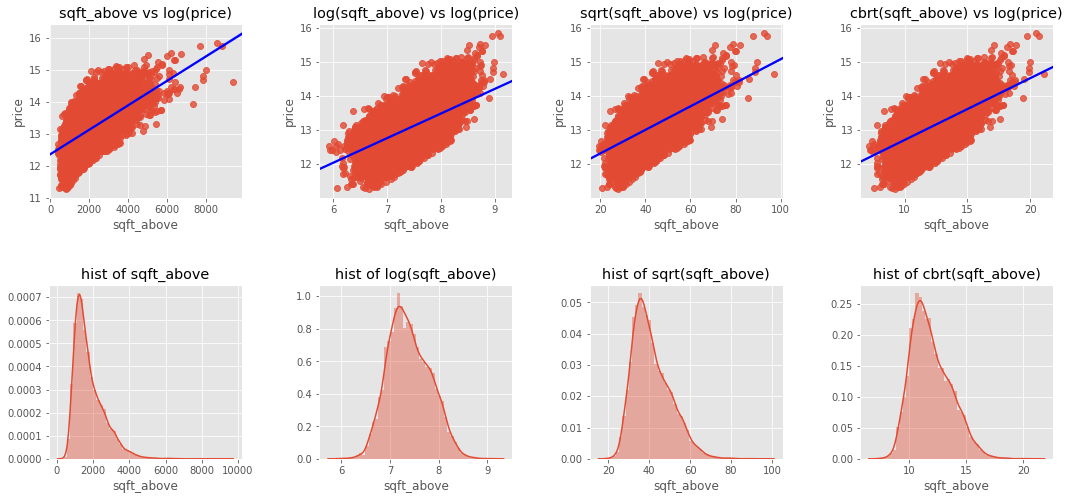

In [485]:
assess_rs_transformation(data_continuous['sqft_above'],data['price'])

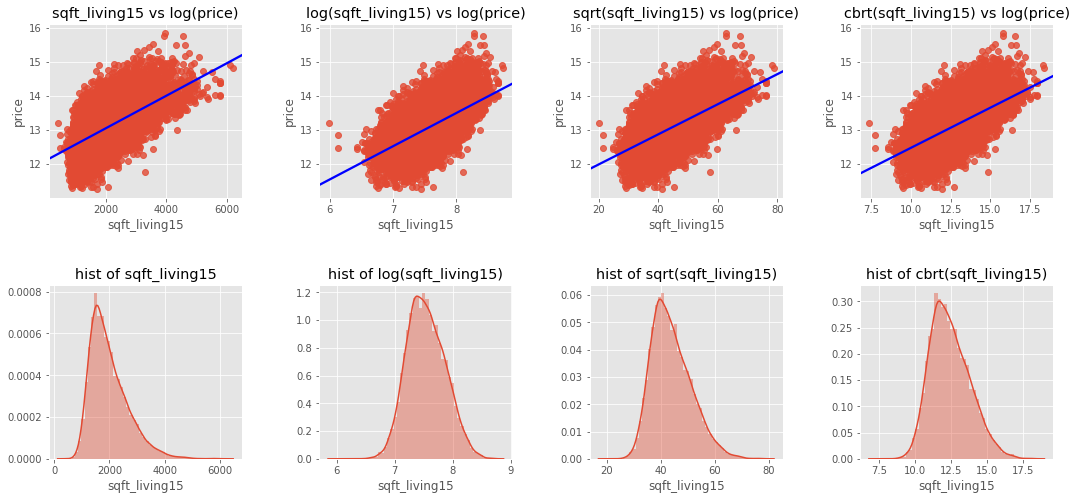

In [486]:
assess_rs_transformation(data_continuous['sqft_living15'],data['price'])

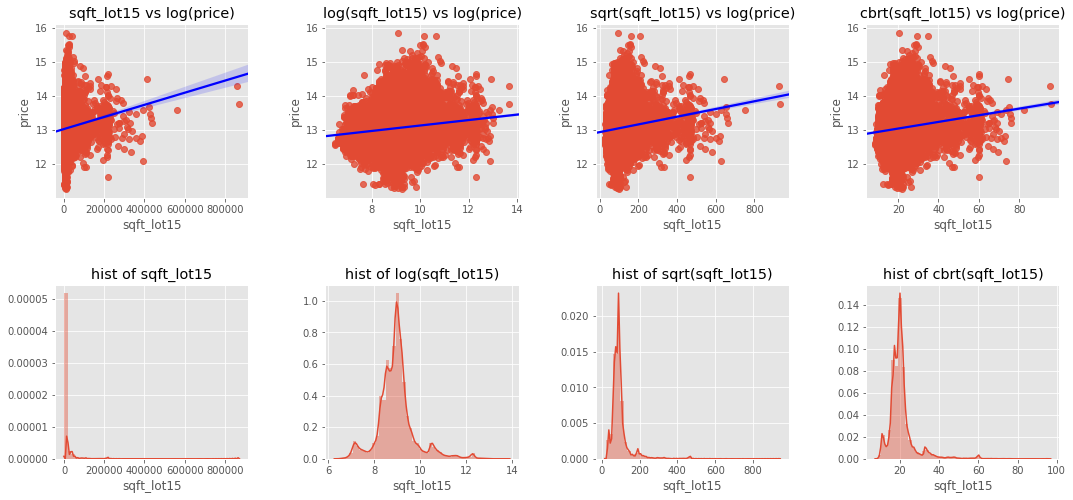

In [487]:
assess_rs_transformation(data_continuous['sqft_lot15'],data['price'])

Based on these plots and the original exploration plots, I've decided on the following transformations:

In [488]:
data['sqft_living'] = np.sqrt(data['sqft_living'])
data['sqft_lot'] = np.cbrt(data['sqft_lot'])
data['sqft_lot15'] = np.log(data['sqft_lot15'])
data['floors'] = np.log(data['floors'])
data['condition'] = np.log(data['condition'])

### Cutting
Now let's handle multi-modality by cutting and binning. I'll make a function that finds the most useful number of quantiles by which to cut.

In [489]:
def ideal_qcut(x,y,min_q=2,max_q=9,verbose=False):
    ''' Finds ideal q value for cutting features into bins
    
    Parameters:
        x (pd.Series) : values to try cutting
        y (pd.Series) : values to regress against
        min_q (int,optional): minimum q value (default: 2)
        max_q (int,optional): maximum q value (default: 9)
        verbose (boolean): whether to read out q value results
        
    Returns:
        list: list of dictionaries containing correlation values per q value
    '''
    results = []
    for i in range(max_q - min_q + 1):
        temp = pd.qcut(x,q=i+min_q,duplicates='drop')
        temp = temp.astype('category').cat.codes
        if verbose:
            print("q = {}: {:.4}".format(i+min_q,np.corrcoef(temp,y)[0][1]))
        results.append({'q':i+min_q,
                        'correlation':np.corrcoef(temp,y)[0][1]})
    return results

Next, I'll make a function that uses `ideal_qcut` to make the cuts. I'l also need a function to compare correlation before and after the cuts.

In [490]:
def compare_correlation(x1,x2,y):
    ''' prints a quick correlation report comparing
        any two features
    
    Parameters:
        x (pd.Series): series containing first feature
        x2 (pd.Series): series containing second feature
        y (pd.Series): series containing target feature
    
    Returns:
        None
    '''
    print('Correlation report:')
    cm = np.round(np.corrcoef([x1,x2],y),4)
    print('{} vs {}: {}'.format(x1.name,y.name,cm[0,2]))
    print('{} vs {}: {}'.format(x2.name,y.name,cm[1,2]))
    print('{} vs {}: {}'.format(x1.name,x2.name,cm[0,1]))

def quant_to_bin(x,y,verbose=True,report=True):
    ''' Cuts quantized feature into best quantile bins
    
    Parameters:
        x (pd.Series): feature to cut
        y (pd.Series): target feature
        verbose (boolean): whether to plot distributions before and after
        report (boolean): whether to provide correlation report
        
    Returns:
        pd.Series: cat-encoded cut feature
    '''
    if verbose:
        # plot unaltered distribution
        fig = plt.figure(figsize=(18,6))
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
        ax = fig.add_subplot(1, 2, 1)
        sns.distplot(x,ax=ax)
    
    # find ideal q value for cutting
    results = ideal_qcut(x,y)
    ideal_q = sorted(results,key=lambda x:x['correlation'],reverse=True)[0]['q']
    
    # cut and categorically encode
    cut = pd.qcut(x,q=ideal_q,duplicates='drop')
    cut = cut.astype('category').cat.codes
    cut.name = 'cut_{}'.format(x.name)
    
    if verbose:
        # plot the altered distrubtion
        ax = fig.add_subplot(1, 2, 2)
        sns.distplot(cut,ax=ax)
        plt.show()

    if report:
        # print a correlation report
        compare_correlation(x,cut,y)
    return cut

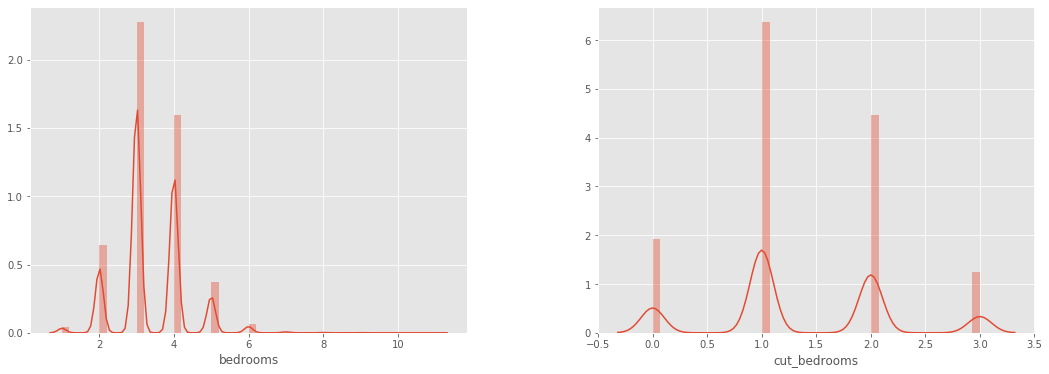

Correlation report:
bedrooms vs price: 0.3508
cut_bedrooms vs price: 0.3544
bedrooms vs cut_bedrooms: 0.9748


In [491]:
# now let's try using the tools
bedrooms_cuts = quant_to_bin(data['bedrooms'],data['price'])

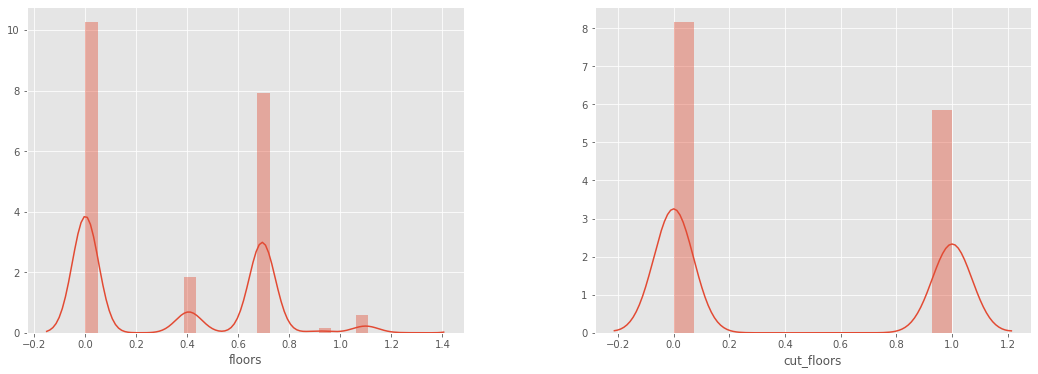

Correlation report:
floors vs price: 0.323
cut_floors vs price: 0.3065
floors vs cut_floors: 0.9288


In [492]:
floors_cuts = quant_to_bin(data['floors'],data['price'])

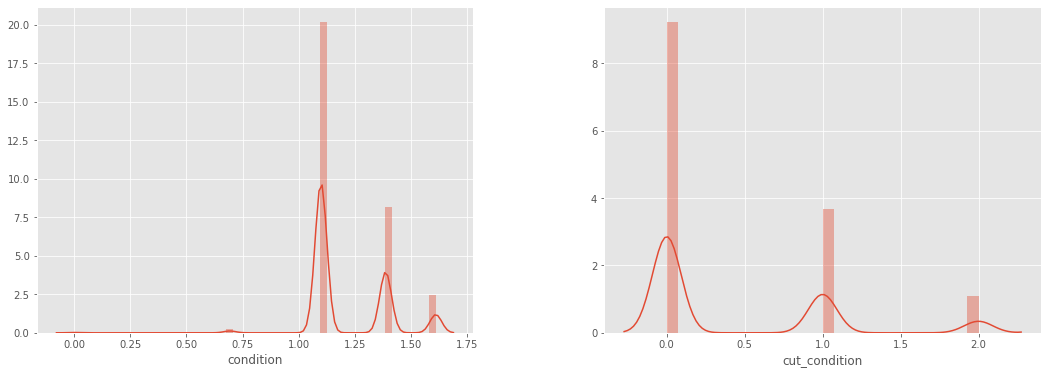

Correlation report:
condition vs price: 0.0432
cut_condition vs price: 0.0236
condition vs cut_condition: 0.9524


In [493]:
condition_cuts = quant_to_bin(np.log(data_quantized['condition']),data['price'])

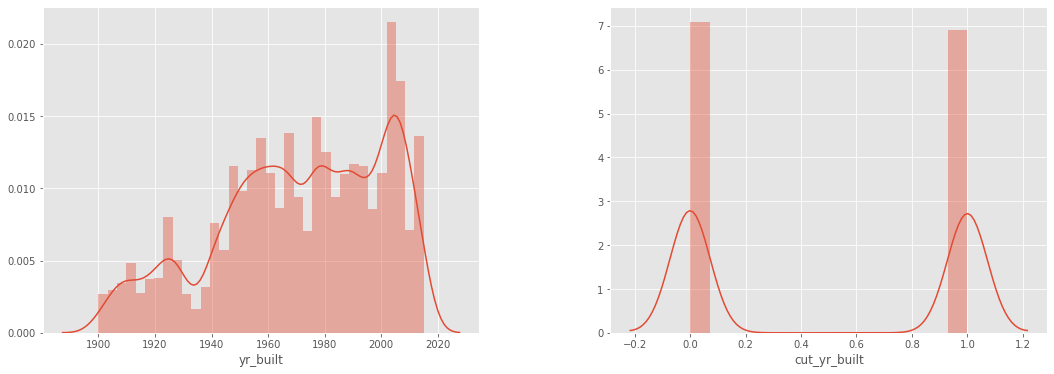

Correlation report:
yr_built vs price: 0.0806
cut_yr_built vs price: 0.1356
yr_built vs cut_yr_built: 0.831


In [494]:
yr_built_cuts = quant_to_bin(data['yr_built'],data['price'])

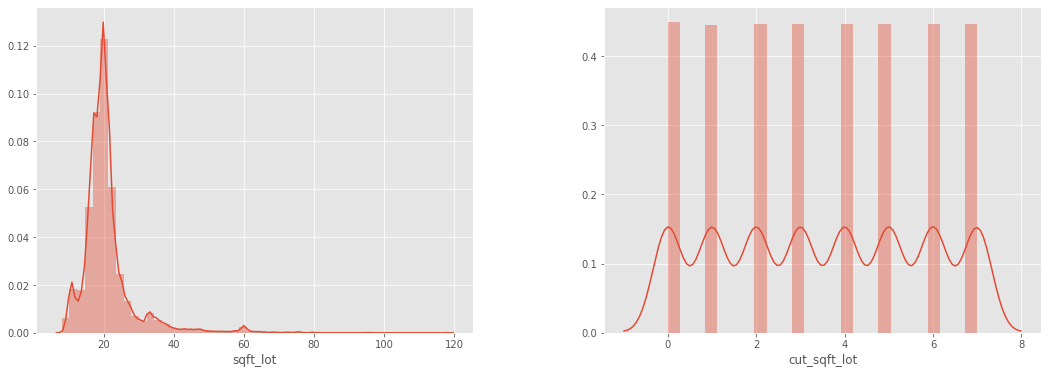

Correlation report:
sqft_lot vs price: 0.1437
cut_sqft_lot vs price: 0.1013
sqft_lot vs cut_sqft_lot: 0.7337


In [495]:
sqft_lot_cuts = quant_to_bin(data['sqft_lot'],data['price'])

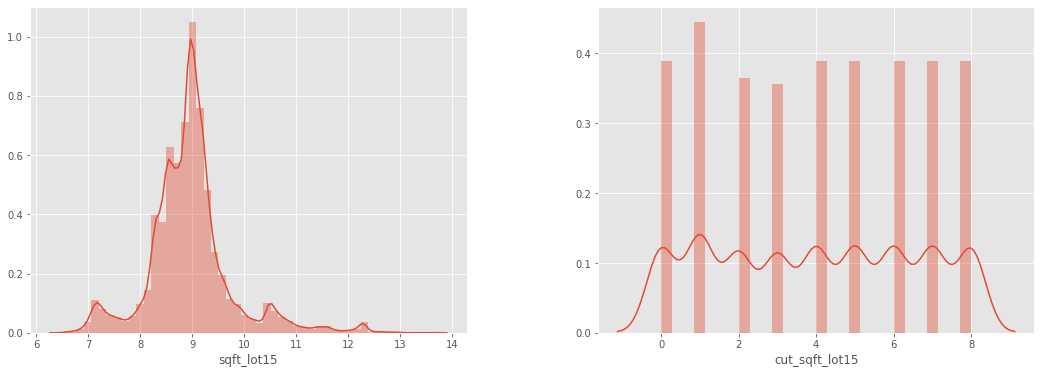

Correlation report:
sqft_lot15 vs price: 0.1237
cut_sqft_lot15 vs price: 0.0883
sqft_lot15 vs cut_sqft_lot15: 0.8614


In [496]:
sqft_lot15_cuts = quant_to_bin(data['sqft_lot15'],data['price'])

It looks like we'll only benefit from cutting `bedrooms` and `yr_built`.

In [497]:
data['bedrooms'] = bedrooms_cuts
data['yr_built'] = yr_built_cuts

Finally, we can drop the support columns, since they won't be useful in regression.

In [498]:
to_drop = ['parcel_number','date','zipcode','lat','long']
for col in to_drop:
    data.drop(col,axis=1,inplace=True)

### One-hot encoding  
Several of our columns are categorical. Let's one-hot encode them, otherwise they don't make much sense in basic linear regression.

In [574]:
onehotted_data = data.copy()
to_onehot = ['nearest_hood', 'School-High','School-Elementary',
             'School-Alternative', 'School-Junior High/Middle',
             'School-College or University', 'School-K-12',
             'bedrooms','yr_built']
for col in to_onehot:
    dummies = pd.get_dummies(onehotted_data[col],prefix=col+'_')
    onehotted_data.drop(col,axis=1,inplace=True)
    onehotted_data = pd.concat([onehotted_data,dummies],join='inner',axis=1)
    
onehotted_data.head()

,price,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,School-K-12__10,School-K-12__11,School-K-12__12,School-K-12__13,School-K-12__14,School-K-12__15,bedrooms__1,bedrooms__2,bedrooms__3,yr_built__1
0,12.309982,1.00,34.351128,17.810775,0.000000,False,0,1.098612,7,1180,...,0,1,0,0,0,0,1,0,0,0
1,13.195614,2.25,50.695167,19.347262,0.693147,False,0,1.098612,7,2170,...,0,0,0,1,0,0,1,0,0,0
2,12.100712,1.00,27.748874,21.544347,0.000000,False,0,1.098612,6,770,...,0,0,0,0,0,0,0,0,0,0
3,13.311329,3.00,44.271887,17.099759,0.000000,False,0,1.609438,7,1050,...,0,0,1,0,0,0,0,1,0,0
4,13.142166,2.00,40.987803,20.066446,0.000000,False,0,1.098612,8,1680,...,0,0,0,0,0,0,1,0,0,1


#### All-column performance  
Some features will probably need to be removed, especially since I didn't drop any columns during one-hot encoding. Dropping them within the dummy-creation function just drops the least populated, but I'd rather drop least-important columns. Before we do that, however, let's see how the data is performing so far.

In [576]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def test(X,y):
    X_train,X_test,y_train,y_test = tts(X,y,test_size=0.3)
    lr = LinearRegression().fit(X_train,y_train)
    preds = lr.predict(X_test)
    print("R-squared score: {}".format(r2_score(y_test,preds)))

X = onehotted_data.copy()
y = X.pop('price')
test(X,y)

R-squared score: 0.897115300361038


In [577]:
X['waterfront'] = X['waterfront'].astype(int)

In [579]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def stepwise_selection(X, y):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    thres_in=0.01
    thresh_out = 0.05
    included = []
    while True:
        changed = False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            print('Drop: {:30}\t\t(p-value {:.3})'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

stepwise_result = stepwise_selection(X, y, verbose=True)

Keep: nearest_hood__20    		(p-value 0.0)
Keep: sqft_living15       		(p-value 0.0)
Keep: nearest_hood__39    		(p-value 0.0)
Keep: School-College or University__7		(p-value 0.0)
Keep: School-K-12__11     		(p-value 0.0)
Keep: sqft_living         		(p-value 0.0)
Keep: dist_hoods          		(p-value 0.0)
Keep: School-K-12__2      		(p-value 0.0)
Keep: grade               		(p-value 0.0)
Keep: waterfront          		(p-value 6.6e-225)
Keep: School-K-12__13     		(p-value 4.45e-229)
Keep: condition           		(p-value 2.85e-215)
Keep: School-College or University__5		(p-value 1.45e-164)
Keep: School-College or University__15		(p-value 4.02e-187)
Keep: School-College or University__21		(p-value 2.01e-127)
Keep: School-College or University__14		(p-value 2.62e-149)
Keep: view                		(p-value 2.15e-132)
Keep: nearest_hood__9     		(p-value 3.81e-118)
Keep: dist_to_School-K-12 		(p-value 7.5e-112)
Drop: School-K-12__11               		(p-value 0.316)


C:\Users\root\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Keep: School-High__5      		(p-value 1.88e-128)
Keep: School-Elementary__219		(p-value 3.35e-95)
Keep: sqft_lot            		(p-value 2e-99)
Keep: nearest_hood__12    		(p-value 5.12e-75)
Keep: nearest_hood__37    		(p-value 1.1e-100)
Keep: nearest_hood__34    		(p-value 8.32e-95)
Drop: School-College or University__14		(p-value 0.681)
Keep: School-Junior High/Middle__11		(p-value 2.48e-75)
Keep: School-Alternative__17		(p-value 1.52e-63)
Keep: sqft_basement       		(p-value 5.46e-57)
Keep: School-Junior High/Middle__7		(p-value 1.63e-60)
Keep: School-Junior High/Middle__22		(p-value 2.48e-51)
Keep: School-Elementary__239		(p-value 1.65e-51)
Keep: School-Alternative__39		(p-value 1.52e-44)
Keep: School-Alternative__9		(p-value 1.87e-45)
Keep: School-Alternative__52		(p-value 1.39e-42)
Keep: School-College or University__18		(p-value 1.49e-44)
Keep: School-Elementary__111		(p-value 1.1e-40)
Keep: nearest_hood__5     		(p-value 2.95e-41)
Keep: yr_renovated        		(p-value 8.75e-39)
Kee

Keep: sqft_lot15          		(p-value 0.00385)
Keep: nearest_hood__26    		(p-value 0.00444)
Keep: School-Elementary__112		(p-value 0.000965)
Keep: School-College or University__2		(p-value 0.00326)
Keep: School-Elementary__285		(p-value 0.00318)
Keep: School-K-12__10     		(p-value 0.00351)
Drop: School-College or University__7		(p-value 0.053)
Keep: School-K-12__6      		(p-value 1.19e-05)
Keep: School-Elementary__111		(p-value 0.00197)
Keep: School-Elementary__318		(p-value 0.000908)
Keep: School-Elementary__320		(p-value 0.00345)
Drop: School-Junior High/Middle__5  		(p-value 0.15)
Keep: School-Alternative__41		(p-value 0.00435)
Keep: School-Elementary__125		(p-value 0.00399)
Keep: School-Elementary__24		(p-value 0.00441)
Keep: School-Alternative__35		(p-value 0.00572)
Keep: School-Junior High/Middle__34		(p-value 0.00608)
Keep: School-Junior High/Middle__23		(p-value 0.0056)
Keep: School-High__15     		(p-value 8.37e-05)
Keep: School-Elementary__126		(p-value 0.00455)
Keep: School-

In [583]:
np.save('stepwise_result.npy',np.array(stepwise_result))

Keep: nearest_hood__20    		(p-value 0.0)
Keep: sqft_living15       		(p-value 0.0)
Keep: nearest_hood__39    		(p-value 0.0)
Keep: School-College or University__7		(p-value 0.0)
Keep: School-K-12__11     		(p-value 0.0)
Keep: sqft_living         		(p-value 0.0)
Keep: dist_hoods          		(p-value 0.0)
Keep: School-K-12__2      		(p-value 0.0)
Keep: grade               		(p-value 0.0)
Keep: waterfront          		(p-value 6.6e-225)
Keep: School-K-12__13     		(p-value 4.45e-229)
Keep: condition           		(p-value 2.85e-215)
Keep: School-College or University__5		(p-value 1.45e-164)
Keep: School-College or University__15		(p-value 4.02e-187)
Keep: School-College or University__21		(p-value 2.01e-127)
Keep: School-College or University__14		(p-value 2.62e-149)
Keep: view                		(p-value 2.15e-132)
Keep: nearest_hood__9     		(p-value 3.81e-118)
Keep: dist_to_School-K-12 		(p-value 7.5e-112)
Drop: School-K-12__11               		(p-value 0.316)
C:\Users\root\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
Keep: School-High__5      		(p-value 1.88e-128)
Keep: School-Elementary__219		(p-value 3.35e-95)
Keep: sqft_lot            		(p-value 2e-99)
Keep: nearest_hood__12    		(p-value 5.12e-75)
Keep: nearest_hood__37    		(p-value 1.1e-100)
Keep: nearest_hood__34    		(p-value 8.32e-95)
Drop: School-College or University__14		(p-value 0.681)
Keep: School-Junior High/Middle__11		(p-value 2.48e-75)
Keep: School-Alternative__17		(p-value 1.52e-63)
Keep: sqft_basement       		(p-value 5.46e-57)
Keep: School-Junior High/Middle__7		(p-value 1.63e-60)
Keep: School-Junior High/Middle__22		(p-value 2.48e-51)
Keep: School-Elementary__239		(p-value 1.65e-51)
Keep: School-Alternative__39		(p-value 1.52e-44)
Keep: School-Alternative__9		(p-value 1.87e-45)
Keep: School-Alternative__52		(p-value 1.39e-42)
Keep: School-College or University__18		(p-value 1.49e-44)
Keep: School-Elementary__111		(p-value 1.1e-40)
Keep: nearest_hood__5     		(p-value 2.95e-41)
Keep: yr_renovated        		(p-value 8.75e-39)
Keep: nearest_hood__31    		(p-value 2.27e-30)
Keep: School-Junior High/Middle__45		(p-value 1.05e-31)
Keep: School-Junior High/Middle__76		(p-value 2.99e-37)
Keep: School-Junior High/Middle__4		(p-value 1.68e-33)
Keep: nearest_hood__32    		(p-value 1.07e-26)
Keep: School-Junior High/Middle__71		(p-value 2.87e-25)
Keep: nearest_hood__14    		(p-value 4.61e-25)
Keep: School-Elementary__85		(p-value 9.77e-26)
Keep: School-Alternative__58		(p-value 4.97e-25)
Keep: School-College or University__24		(p-value 7.48e-25)
Keep: School-Junior High/Middle__5		(p-value 4.64e-24)
Keep: School-High__10     		(p-value 2.33e-24)
Keep: School-Junior High/Middle__14		(p-value 1.36e-27)
Keep: School-High__32     		(p-value 1.71e-24)
Keep: School-Elementary__269		(p-value 5.22e-22)
Keep: School-Elementary__314		(p-value 1.31e-20)
Keep: nearest_hood__7     		(p-value 3.79e-20)
Keep: School-Elementary__289		(p-value 3.13e-17)
Keep: School-Junior High/Middle__18		(p-value 1.15e-16)
Keep: School-Junior High/Middle__30		(p-value 5.1e-16)
Keep: School-Elementary__159		(p-value 2.77e-15)
Keep: School-High__48     		(p-value 3.13e-15)
Keep: sqft_above          		(p-value 5.81e-14)
Keep: School-Elementary__252		(p-value 2.55e-13)
Keep: School-Elementary__8		(p-value 9.74e-14)
Keep: nearest_hood__44    		(p-value 8.02e-15)
Keep: nearest_hood__38    		(p-value 1.12e-18)
Keep: nearest_hood__41    		(p-value 1.09e-15)
Keep: nearest_hood__35    		(p-value 5.26e-16)
Keep: School-Junior High/Middle__77		(p-value 5.96e-18)
Keep: nearest_hood__6     		(p-value 6.19e-16)
Keep: School-Elementary__68		(p-value 9.56e-16)
Keep: School-Elementary__180		(p-value 4.58e-15)
Keep: School-Elementary__92		(p-value 2.74e-14)
Keep: bathrooms           		(p-value 1.07e-13)
Keep: floors              		(p-value 1.8e-14)
Keep: School-Junior High/Middle__62		(p-value 2.57e-13)
Keep: School-Junior High/Middle__1		(p-value 1.42e-12)
Keep: School-Alternative__53		(p-value 1.32e-12)
Drop: School-High__32               		(p-value 0.149)
Keep: School-Junior High/Middle__24		(p-value 1.41e-12)
Keep: School-Junior High/Middle__8		(p-value 1.24e-12)
Keep: nearest_hood__33    		(p-value 5.02e-13)
Keep: School-Elementary__160		(p-value 1.52e-11)
Keep: School-Alternative__14		(p-value 2.75e-11)
Keep: School-Alternative__26		(p-value 4.49e-11)
Drop: School-College or University__18		(p-value 0.182)
Keep: School-High__41     		(p-value 9.67e-12)
Keep: School-Alternative__2		(p-value 1.93e-11)
Keep: School-Elementary__233		(p-value 1.21e-10)
Keep: School-Junior High/Middle__36		(p-value 4.29e-10)
Keep: School-Junior High/Middle__70		(p-value 3.12e-09)
Keep: School-K-12__4      		(p-value 2.46e-08)
Keep: nearest_hood__16    		(p-value 3.53e-08)
Keep: School-Alternative__48		(p-value 1.08e-07)
Keep: School-Junior High/Middle__50		(p-value 1.52e-07)
Keep: School-Elementary__240		(p-value 1.94e-07)
Keep: School-College or University__6		(p-value 2.22e-07)
Keep: nearest_hood__15    		(p-value 2.62e-07)
Keep: nearest_hood__3     		(p-value 1.18e-08)
Keep: School-Elementary__157		(p-value 7.61e-08)
Keep: School-Alternative__7		(p-value 1.44e-08)
Keep: School-Elementary__143		(p-value 1.27e-07)
Keep: nearest_hood__18    		(p-value 2.64e-07)
Drop: School-Elementary__111        		(p-value 0.055)
Keep: bedrooms__3         		(p-value 6.84e-07)
Keep: School-Junior High/Middle__37		(p-value 7.36e-07)
Keep: School-College or University__13		(p-value 1.11e-06)
Keep: School-Elementary__293		(p-value 2.14e-07)
Keep: School-Elementary__88		(p-value 1.17e-06)
Keep: School-High__22     		(p-value 1.87e-06)
Keep: School-Elementary__280		(p-value 2.07e-06)
Keep: School-High__17     		(p-value 2.66e-06)
Keep: School-High__56     		(p-value 1.63e-06)
Keep: School-Elementary__104		(p-value 3.25e-06)
Keep: School-High__16     		(p-value 4.17e-06)
Keep: School-Elementary__71		(p-value 3.09e-06)
Keep: School-Elementary__142		(p-value 4.38e-06)
Keep: School-College or University__25		(p-value 5.23e-06)
Keep: School-Elementary__161		(p-value 6.12e-06)
Keep: School-Alternative__13		(p-value 7.15e-06)
Keep: School-Elementary__44		(p-value 8.85e-06)
Keep: School-Elementary__200		(p-value 6.25e-06)
Keep: nearest_hood__19    		(p-value 9.41e-06)
Keep: School-Elementary__307		(p-value 8.93e-06)
Keep: School-Alternative__32		(p-value 6.93e-06)
Keep: School-Elementary__248		(p-value 7.01e-07)
Keep: School-Junior High/Middle__65		(p-value 3.76e-05)
Keep: School-High__43     		(p-value 3.06e-05)
Keep: nearest_hood__24    		(p-value 5.53e-05)
Keep: nearest_hood__42    		(p-value 3.84e-07)
Keep: School-Junior High/Middle__55		(p-value 5.73e-05)
Keep: School-Elementary__251		(p-value 5.82e-05)
Keep: School-Elementary__196		(p-value 8.69e-05)
Keep: School-Alternative__45		(p-value 7.56e-05)
Keep: nearest_hood__40    		(p-value 0.000101)
Keep: School-Junior High/Middle__38		(p-value 0.000101)
Drop: School-College or University__5		(p-value 0.128)
Keep: School-Elementary__199		(p-value 9.88e-05)
Keep: School-Elementary__47		(p-value 0.000104)
Keep: School-Alternative__8		(p-value 0.000119)
Keep: School-Elementary__20		(p-value 0.000129)
Keep: School-Elementary__267		(p-value 0.000128)
Keep: nearest_hood__43    		(p-value 0.000123)
Keep: School-Elementary__141		(p-value 0.000243)
Keep: School-Elementary__172		(p-value 0.000256)
Keep: School-College or University__19		(p-value 0.000349)
Keep: School-Elementary__17		(p-value 0.000305)
Keep: School-Elementary__49		(p-value 0.000357)
Keep: nearest_hood__28    		(p-value 0.000448)
Keep: School-Elementary__110		(p-value 0.000358)
Keep: School-Elementary__235		(p-value 0.000443)
Keep: School-Alternative__50		(p-value 0.000387)
Keep: School-Alternative__42		(p-value 0.000506)
Keep: School-High__37     		(p-value 6.03e-05)
Keep: School-Elementary__178		(p-value 0.000409)
Keep: nearest_hood__25    		(p-value 0.00021)
Keep: School-Elementary__53		(p-value 0.00038)
Keep: School-Alternative__22		(p-value 4.48e-08)
Keep: School-Junior High/Middle__39		(p-value 1.13e-06)
Drop: School-Elementary__53         		(p-value 0.159)
Keep: School-Elementary__60		(p-value 0.000642)
Keep: School-High__62     		(p-value 0.000729)
Keep: School-Alternative__24		(p-value 0.000814)
Keep: School-Elementary__138		(p-value 0.00107)
Keep: School-Elementary__242		(p-value 0.00147)
Keep: School-K-12__7      		(p-value 0.00116)
Keep: School-Elementary__204		(p-value 0.00185)
Keep: School-Elementary__275		(p-value 0.0016)
Drop: School-Elementary__85         		(p-value 0.0536)
Keep: School-Elementary__16		(p-value 0.00203)
Keep: yr_built__1         		(p-value 0.00214)
Keep: School-Elementary__107		(p-value 0.00244)
Keep: School-Elementary__164		(p-value 0.00289)
Keep: School-K-12__11     		(p-value 0.00271)
Keep: School-Elementary__238		(p-value 0.00304)
Keep: School-Junior High/Middle__44		(p-value 0.00309)
Keep: School-High__65     		(p-value 0.000339)
Keep: School-K-12__12     		(p-value 0.00209)
Keep: School-High__39     		(p-value 0.00119)
Keep: School-K-12__9      		(p-value 0.000574)
Drop: nearest_hood__25              		(p-value 0.0517)
Keep: School-Elementary__151		(p-value 0.0016)
Keep: School-Alternative__54		(p-value 0.00345)
Keep: School-Elementary__165		(p-value 0.0014)
Keep: sqft_lot15          		(p-value 0.00385)
Keep: nearest_hood__26    		(p-value 0.00444)
Keep: School-Elementary__112		(p-value 0.000965)
Keep: School-College or University__2		(p-value 0.00326)
Keep: School-Elementary__285		(p-value 0.00318)
Keep: School-K-12__10     		(p-value 0.00351)
Drop: School-College or University__7		(p-value 0.053)
Keep: School-K-12__6      		(p-value 1.19e-05)
Keep: School-Elementary__111		(p-value 0.00197)
Keep: School-Elementary__318		(p-value 0.000908)
Keep: School-Elementary__320		(p-value 0.00345)
Drop: School-Junior High/Middle__5  		(p-value 0.15)
Keep: School-Alternative__41		(p-value 0.00435)
Keep: School-Elementary__125		(p-value 0.00399)
Keep: School-Elementary__24		(p-value 0.00441)
Keep: School-Alternative__35		(p-value 0.00572)
Keep: School-Junior High/Middle__34		(p-value 0.00608)
Keep: School-Junior High/Middle__23		(p-value 0.0056)
Keep: School-High__15     		(p-value 8.37e-05)
Keep: School-Elementary__126		(p-value 0.00455)
Keep: School-High__63     		(p-value 0.00203)
Keep: School-Elementary__305		(p-value 0.00589)
Keep: School-Elementary__278		(p-value 0.00713)
Keep: School-Elementary__158		(p-value 0.00991)
Keep: School-Elementary__57		(p-value 0.0096)
Keep: School-Junior High/Middle__57		(p-value 0.000996)
Drop: School-K-12__13               		(p-value 0.0866)
Keep: School-Elementary__186		(p-value 0.00661)
Keep: School-Junior High/Middle__26		(p-value 0.0079)
Keep: School-Elementary__217		(p-value 0.00911)
Keep: School-Elementary__273		(p-value 0.00545)
Keep: School-Junior High/Middle__31		(p-value 0.00931)
Keep: School-Junior High/Middle__43		(p-value 0.00321)
Drop: School-Alternative__35        		(p-value 0.0705)

In [584]:
to_drop = ['School-K-12__11','School-College or University__14','School-High__32',
           'School-College or University__18','School-Elementary__111',
           'School-College or University__5','School-Elementary__53',
           'School-Elementary__85','nearest_hood__25',
           'School-College or University__7','School-Junior High/Middle__5',
           'School-K-12__13','School-Alternative__35']

for col in to_drop:
    X.drop(col,axis=1,inplace=True)

In [587]:
test(X,y)

R-squared score: 0.8979503838466848


In [595]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X.to_numpy())
y_scaled = y_scaler.fit_transform(y.to_numpy().reshape((-1,1)))

test(X_scaled,y_scaled)

R-squared score: 0.9003609213930547


In [ ]:
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

X_train,X_test,y_train,y_test = tts(X_scaled,y_scaled,test_size=0.3)

K.clear_session()

reduce_lr = ReduceLROnPlateau(patience=5,verbose=1)
early_stop = EarlyStopping(patience=8,verbose=1)

entry = L.Input(shape=(632,))
x = L.Dense(1024,activation='relu')(entry)
x = L.LeakyReLU()(x)
x = L.Dense(128,activation='relu',kernel_regularizer=l2(2e-3))(x)
x = L.Dense(1)(x)

model = Model(entry,x)
model.compile(loss='mse',optimizer=Adam(lr=1e-3))
model.fit(X_train,y_train,validation_split=0.2,verbose=2,epochs=9999,
          callbacks=[reduce_lr,early_stop])

r2_score(y_test,model.predict(X_test))

Train on 12093 samples, validate on 3024 samples
Epoch 1/9999
12093/12093 - 4s - loss: 0.0689 - val_loss: 0.0037
Epoch 2/9999
12093/12093 - 3s - loss: 0.0025 - val_loss: 0.0020
Epoch 3/9999
12093/12093 - 3s - loss: 0.0019 - val_loss: 0.0019
Epoch 4/9999
12093/12093 - 3s - loss: 0.0018 - val_loss: 0.0018
Epoch 5/9999
12093/12093 - 3s - loss: 0.0017 - val_loss: 0.0018
Epoch 6/9999
12093/12093 - 3s - loss: 0.0017 - val_loss: 0.0017
Epoch 7/9999
12093/12093 - 3s - loss: 0.0016 - val_loss: 0.0021
Epoch 8/9999
12093/12093 - 3s - loss: 0.0016 - val_loss: 0.0016
Epoch 9/9999
12093/12093 - 3s - loss: 0.0015 - val_loss: 0.0017
Epoch 10/9999
12093/12093 - 3s - loss: 0.0015 - val_loss: 0.0017
Epoch 11/9999

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
12093/12093 - 3s - loss: 0.0015 - val_loss: 0.0018
Epoch 12/9999
12093/12093 - 4s - loss: 0.0012 - val_loss: 0.0015
Epoch 13/9999
12093/12093 - 4s - loss: 0.0011 - val_loss: 0.0015
